In [ ]:
#! pip install overpy  
#! pip install routingpy
#! pip install gym
#! pip install tianshou
#! pip install ray
#! pip install torch
#! pip install scipy
#! pip install matplotlib

# Graph libs
#! pip install networkx[default]
#! pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html
#! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [1]:
#!source venv/bin/activate

In [2]:
# Importing required libraries

import os 
import sys
import random
import argparse
from datetime import datetime
import warnings
warnings.simplefilter('ignore')


import gym
from gym import spaces

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter


In [3]:
# Modules from tianshou framework

import tianshou
from typing import Any, Callable, List, Optional, Tuple, Union, Dict
from tianshou.env import DummyVectorEnv
from tianshou.data import Batch, to_torch, to_torch_as
from tianshou.policy import BasePolicy
from tianshou.utils import TensorboardLogger
import networkx as nx
#import dgl


from tianshou.env.worker import (
    DummyEnvWorker,
    EnvWorker,
    RayEnvWorker,
    SubprocEnvWorker,
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.get_device_properties(device)

In [5]:
# Derived modules and custom defined classes

from env.VRPEnv import VRPEnv
from policy.VRPPolicy import REINFORCEPolicy
from nets.attention_model_D1 import AttentionModel


from data.VRPCollector import Collector
from data.BufferManager import ReplayBuffer, VectorReplayBuffer
from policy.VRPtrainer import OnpolicyTrainer, onpolicy_trainer
from data.Graph_Viz import decode_buffer, generate_tours, plot_vehicle_routes

In [6]:
# Load the saved train and test graphs dataset
graph_size = 10
train_size = 50000
test_size = 10000

train_data_path = "./data/train/"+ f"train_graphs_{train_size}x20.pickle"
test_data_path = "./data/test/"+ f"test_graphs_{test_size}x10.pickle"

with open(train_data_path, 'rb') as train_handle:
    load_train_graphs = pickle.load(train_handle)
    
with open(test_data_path, 'rb') as test_handle:
    load_test_graphs = pickle.load(test_handle)  

In [7]:
# Visualizing underlying Network graph
#options = {
#    'node_color': 'red',
#    'node_size': 100,
#    'width': 0.5}
#
#g1 = load_test_graphs[500]
#G = DGL_graph(g1)
#G_nx = dgl.to_networkx(G)
#plt.figure(figsize=[15,7])
#nx.draw(G_nx, **options)

In [8]:
# A peak into generated instances

print(f"# of Training graphs: {len(load_train_graphs)}")
print(f"# of Test graphs: {len(load_test_graphs)}")

n = 10
print("\n", load_train_graphs[n]["node_features"])
print("\n", load_test_graphs[n]["node_features"])

# of Training graphs: 50000
# of Test graphs: 10000

 tensor([[1.0000, 0.0000, 0.0000, 0.4083, 0.6972],
        [0.0000, 1.0000, 0.1500, 0.4148, 0.4940],
        [0.0000, 1.0000, 0.1800, 0.3158, 0.2706],
        [0.0000, 1.0000, 0.3100, 0.4745, 0.4073],
        [0.0000, 1.0000, 0.4900, 0.4215, 0.6700],
        [0.0000, 1.0000, 0.3600, 0.4190, 0.2895],
        [0.0000, 1.0000, 0.3300, 0.5436, 0.6490],
        [0.0000, 1.0000, 0.1600, 0.3523, 0.6703],
        [0.0000, 1.0000, 0.2700, 0.4023, 0.7152],
        [0.0000, 1.0000, 0.2000, 0.9945, 0.1802],
        [0.0000, 1.0000, 0.2100, 0.2841, 0.5035],
        [0.0000, 1.0000, 0.3100, 0.6286, 0.6463],
        [0.0000, 1.0000, 0.1700, 0.5398, 0.3811],
        [0.0000, 1.0000, 0.1100, 0.4692, 0.6285],
        [0.0000, 1.0000, 0.4100, 0.4348, 0.6667],
        [0.0000, 1.0000, 0.3400, 0.5552, 0.5479],
        [0.0000, 1.0000, 0.1100, 0.3485, 0.5273],
        [0.0000, 1.0000, 0.3200, 0.6069, 1.0000],
        [0.0000, 1.0000, 0.1800, 0.3758, 0.407

In [9]:
print(tianshou.__version__)

0.4.10


In [ ]:
# Setting up Vectorized environments for train and test datasets

train_envs = DummyVectorEnv([lambda instance=graph, idx=i: VRPEnv(instance, idx) for i,graph in enumerate(load_train_graphs)])
test_envs = DummyVectorEnv([lambda instance=graph, idx=i: VRPEnv(instance, idx) for i,graph in enumerate(load_test_graphs)])

In [10]:
# Training parameters

training_params = {
    "experiment_idx" : "D1",
    
    # Optimization
    "learning_rate" : 0.00005,
    "betas" : (0.9, 0.99), # coefficients used for computing running averages of gradient and its square
    "weight_decay" : 0.005,  # weight decay coefficient for regularization
    "n_epochs" : 30,
    "batch_size" : 256,
    
    #Model configuration
    "embedding_dim" : 64,
    "hidden_dim" : 16,
    "n_encode_layers" : 2,
    
    # Trainer and Collector setup (will remain almost same, increase buffer sizes for larger datasets)
    "graph_size" : load_train_graphs[0]["node_features"].shape[0] - 1,
    "train_graphs" : len(load_train_graphs),
    "test_graphs" : len(load_test_graphs),
    "train_buffer_size" : 1000000,
    "test_buffer_size" : 1000000,
    "repeat_per_collect" : 1,
    "test_in_train" : True,
    
}

training_params["episode_per_collect"] = training_params["episode_per_test"] = training_params["train_graphs"]
training_params["step_per_epoch"] = training_params["graph_size"] * training_params["train_graphs"]
training_params

{'experiment_idx': 'D1',
 'learning_rate': 5e-05,
 'betas': (0.9, 0.99),
 'weight_decay': 0.005,
 'n_epochs': 30,
 'batch_size': 256,
 'embedding_dim': 64,
 'hidden_dim': 16,
 'n_encode_layers': 2,
 'graph_size': 10,
 'train_graphs': 10000,
 'test_graphs': 5000,
 'train_buffer_size': 1000000,
 'test_buffer_size': 1000000,
 'repeat_per_collect': 1,
 'test_in_train': True,
 'episode_per_collect': 10000,
 'episode_per_test': 10000,
 'step_per_epoch': 100000}

In [11]:
# Setup Model, Optimizer and Policy (Agent) 

model = AttentionModel(
        embedding_dim=64,
        hidden_dim=16,
        graph_size = training_params["graph_size"],
        n_encode_layers=2,
        tanh_clipping=10.,
        mask_inner=True, 
        mask_logits=True,
        normalization='batch',
        n_heads=8,
        checkpoint_encoder=False,
        shrink_size=None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = torch.optim.AdamW(
        model.parameters(), 
        lr=training_params["learning_rate"],
        betas=training_params["betas"], 
        weight_decay=training_params["weight_decay"],
        eps=1e-08)


VRPpolicy = REINFORCEPolicy(model, optim)

In [12]:
# Setting up Replay Buffers and Collectors

test_replaybuffer = VectorReplayBuffer(training_params["test_buffer_size"], buffer_num=training_params["test_graphs"])
train_replaybuffer = VectorReplayBuffer(training_params["train_buffer_size"], buffer_num=training_params["train_graphs"])

test_collector = Collector(VRPpolicy, test_envs, test_replaybuffer)
train_collector = Collector(VRPpolicy, train_envs, train_replaybuffer)

Collector reset!
Collector reset!


In [13]:
# Setting up trainer 

logdir = "./logs/"
exp_num = training_params["experiment_idx"]

# Setup Tensorboard logger
log_path = os.path.join(logdir, f"VRPtraining_exp{exp_num}")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)


train_replaybuffer.reset()
test_replaybuffer.reset()

trainer = OnpolicyTrainer(
    VRPpolicy,
    train_collector,
    test_collector,
    max_epoch = training_params["n_epochs"],
    step_per_epoch = training_params["step_per_epoch"],
    repeat_per_collect = training_params["repeat_per_collect"],
    episode_per_test = training_params["episode_per_test"],
    episode_per_collect = training_params["episode_per_collect"],
    batch_size = training_params["batch_size"],
    logger=logger)

In [ ]:
# Train the model and store epoch stats in a dataframe

losses = []
train_stat = []

for epoch, epoch_stat, info in trainer:
    print("Epoch:", epoch)
    print(epoch_stat)
    print("\n")
    #print(info)
    losses.append(-epoch_stat["loss"])
    epoch_stat["epoch"] = epoch
    train_stat.append(epoch_stat)
    
train_df_cols = epoch_stat.keys()
train_df = pd.DataFrame(train_stat, columns = train_df_cols)
#train_df

Epoch #1: 129771it [02:07, 1018.10it/s, bl_rew=78.11, env_step=129771, len=12, loss=-70.822, n/ep=10000, n/st=129771, rew=102.81]


Epoch #1: test_reward: 95.164130 ± 24.376986, best_reward: 95.164130 ± 24.376986 in #1
Epoch: 1
{'test_reward': 95.1641305, 'test_reward_std': 24.37698583950862, 'best_reward': 95.1641305, 'best_reward_std': 24.37698583950862, 'best_epoch': 1, 'loss': -70.8220204925537, 'gradient_step': 506, 'env_step': 129771, 'rew': 102.8085619, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129771}




Epoch #2: 129934it [02:55, 738.76it/s, bl_rew=78.11, env_step=259705, len=12, loss=-32.592, n/ep=10000, n/st=129934, rew=94.66] 


Epoch #2: test_reward: 93.531491 ± 24.290784, best_reward: 93.531491 ± 24.290784 in #2
Epoch: 2
{'test_reward': 93.53149056000001, 'test_reward_std': 24.29078422400691, 'best_reward': 93.53149056000001, 'best_reward_std': 24.29078422400691, 'best_epoch': 2, 'loss': -32.5915949344635, 'gradient_step': 1013, 'env_step': 259705, 'rew': 94.66231280000001, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129934}




Epoch #3: 129727it [02:40, 808.79it/s, bl_rew=78.11, env_step=389432, len=12, loss=-31.351, n/ep=10000, n/st=129727, rew=93.31] 


Epoch #3: test_reward: 95.294645 ± 24.636420, best_reward: 93.531491 ± 24.290784 in #2
Epoch: 3
{'test_reward': 95.29464482, 'test_reward_std': 24.636420480574387, 'best_reward': 93.53149056000001, 'best_reward_std': 24.29078422400691, 'best_epoch': 2, 'loss': -31.350643625259398, 'gradient_step': 1519, 'env_step': 389432, 'rew': 93.30901441, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129727}




Epoch #4: 129864it [03:17, 656.91it/s, bl_rew=78.11, env_step=519296, len=12, loss=-39.797, n/ep=10000, n/st=129864, rew=95.52] 


Epoch #4: test_reward: 93.980357 ± 23.695659, best_reward: 93.531491 ± 24.290784 in #2
Epoch: 4
{'test_reward': 93.98035723999999, 'test_reward_std': 23.695658800552973, 'best_reward': 93.53149056000001, 'best_reward_std': 24.29078422400691, 'best_epoch': 2, 'loss': -39.79703191757202, 'gradient_step': 2026, 'env_step': 519296, 'rew': 95.52021626, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129864}




Epoch #5: 129802it [03:24, 635.51it/s, bl_rew=78.11, env_step=649098, len=12, loss=-51.773, n/ep=10000, n/st=129802, rew=93.81] 


Epoch #5: test_reward: 96.391674 ± 23.269362, best_reward: 93.531491 ± 24.290784 in #2
Epoch: 5
{'test_reward': 96.39167413999999, 'test_reward_std': 23.269361641903142, 'best_reward': 93.53149056000001, 'best_reward_std': 24.29078422400691, 'best_epoch': 2, 'loss': -51.77323572158814, 'gradient_step': 2533, 'env_step': 649098, 'rew': 93.80867520999999, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129802}




Epoch #6: 129797it [03:27, 625.96it/s, bl_rew=78.11, env_step=778895, len=12, loss=-46.118, n/ep=10000, n/st=129797, rew=96.28] 


Epoch #6: test_reward: 91.538372 ± 23.143479, best_reward: 91.538372 ± 23.143479 in #6
Epoch: 6
{'test_reward': 91.53837236, 'test_reward_std': 23.143479062114324, 'best_reward': 91.53837236, 'best_reward_std': 23.143479062114324, 'best_epoch': 6, 'loss': -46.11791963577271, 'gradient_step': 3040, 'env_step': 778895, 'rew': 96.27784472999998, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129797}




Epoch #7: 129823it [03:28, 621.62it/s, bl_rew=78.11, env_step=908718, len=12, loss=-38.448, n/ep=10000, n/st=129823, rew=91.16] 


Epoch #7: test_reward: 96.903914 ± 22.382721, best_reward: 91.538372 ± 23.143479 in #6
Epoch: 7
{'test_reward': 96.90391387999999, 'test_reward_std': 22.382721326862185, 'best_reward': 91.53837236, 'best_reward_std': 23.143479062114324, 'best_epoch': 6, 'loss': -38.44801399230957, 'gradient_step': 3547, 'env_step': 908718, 'rew': 91.1574204, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129823}




Epoch #8: 129787it [03:19, 651.43it/s, bl_rew=78.11, env_step=1038505, len=12, loss=-55.691, n/ep=10000, n/st=129787, rew=96.79] 


Epoch #8: test_reward: 90.582170 ± 22.630821, best_reward: 90.582170 ± 22.630821 in #8
Epoch: 8
{'test_reward': 90.58217022, 'test_reward_std': 22.630820533465666, 'best_reward': 90.58217022, 'best_reward_std': 22.630820533465666, 'best_epoch': 8, 'loss': -55.69061729431152, 'gradient_step': 4053, 'env_step': 1038505, 'rew': 96.78835061, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129787}




Epoch #9: 129760it [03:41, 586.71it/s, bl_rew=78.11, env_step=1168265, len=12, loss=-31.741, n/ep=10000, n/st=129760, rew=90.59] 


Epoch #9: test_reward: 93.573189 ± 21.537861, best_reward: 90.582170 ± 22.630821 in #8
Epoch: 9
{'test_reward': 93.57318914, 'test_reward_std': 21.53786060193417, 'best_reward': 90.58217022, 'best_reward_std': 22.630820533465666, 'best_epoch': 8, 'loss': -31.74059362411499, 'gradient_step': 4559, 'env_step': 1168265, 'rew': 90.59231789000002, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129760}




Epoch #10: 129670it [03:38, 593.68it/s, bl_rew=78.11, env_step=1297935, len=12, loss=-41.454, n/ep=10000, n/st=129670, rew=93.60] 


Epoch #10: test_reward: 89.450195 ± 22.025135, best_reward: 89.450195 ± 22.025135 in #10
Epoch: 10
{'test_reward': 89.45019477999999, 'test_reward_std': 22.025135153840278, 'best_reward': 89.45019477999999, 'best_reward_std': 22.025135153840278, 'best_epoch': 10, 'loss': -41.45388341903686, 'gradient_step': 5065, 'env_step': 1297935, 'rew': 93.60198992999999, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129670}




Epoch #11: 129760it [03:28, 623.34it/s, bl_rew=78.11, env_step=1427695, len=12, loss=-25.002, n/ep=10000, n/st=129760, rew=88.98] 


Epoch #11: test_reward: 92.299915 ± 21.193322, best_reward: 89.450195 ± 22.025135 in #10
Epoch: 11
{'test_reward': 92.29991534, 'test_reward_std': 21.193322195260247, 'best_reward': 89.45019477999999, 'best_reward_std': 22.025135153840278, 'best_epoch': 10, 'loss': -25.00186179637909, 'gradient_step': 5571, 'env_step': 1427695, 'rew': 88.98420627, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129760}




Epoch #12: 129615it [03:25, 631.90it/s, bl_rew=78.11, env_step=1557310, len=12, loss=-36.695, n/ep=10000, n/st=129615, rew=91.82] 


Epoch #12: test_reward: 88.403364 ± 21.621679, best_reward: 88.403364 ± 21.621679 in #12
Epoch: 12
{'test_reward': 88.4033645, 'test_reward_std': 21.62167890192521, 'best_reward': 88.4033645, 'best_reward_std': 21.62167890192521, 'best_epoch': 12, 'loss': -36.694856357574466, 'gradient_step': 6077, 'env_step': 1557310, 'rew': 91.81882903, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129615}




Epoch #13: 129699it [03:29, 619.43it/s, bl_rew=78.11, env_step=1687009, len=12, loss=-21.419, n/ep=10000, n/st=129699, rew=88.70] 


Epoch #13: test_reward: 90.023715 ± 22.057422, best_reward: 88.403364 ± 21.621679 in #12
Epoch: 13
{'test_reward': 90.02371544, 'test_reward_std': 22.057421756936815, 'best_reward': 88.4033645, 'best_reward_std': 21.62167890192521, 'best_epoch': 12, 'loss': -21.419138984680174, 'gradient_step': 6583, 'env_step': 1687009, 'rew': 88.69892335000002, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129699}




Epoch #14: 129585it [03:23, 637.05it/s, bl_rew=78.11, env_step=1816594, len=12, loss=-25.277, n/ep=10000, n/st=129585, rew=89.81] 


Epoch #14: test_reward: 86.071268 ± 21.958216, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 14
{'test_reward': 86.07126795999999, 'test_reward_std': 21.958215756597287, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -25.27681956291199, 'gradient_step': 7089, 'env_step': 1816594, 'rew': 89.80566918000001, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129585}




Epoch #15: 129671it [03:11, 677.05it/s, bl_rew=78.11, env_step=1946265, len=12, loss=-15.886, n/ep=10000, n/st=129671, rew=85.60] 


Epoch #15: test_reward: 88.112600 ± 22.193441, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 15
{'test_reward': 88.11259962, 'test_reward_std': 22.19344121585938, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -15.886258689165116, 'gradient_step': 7595, 'env_step': 1946265, 'rew': 85.59824332, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129671}




Epoch #16: 129530it [03:18, 654.10it/s, bl_rew=78.11, env_step=2075795, len=12, loss=-17.316, n/ep=10000, n/st=129530, rew=87.69] 


Epoch #16: test_reward: 87.005287 ± 21.997823, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 16
{'test_reward': 87.0052869, 'test_reward_std': 21.997823230324002, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -17.31553747177124, 'gradient_step': 8100, 'env_step': 2075795, 'rew': 87.6861791, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129530}




Epoch #17: 129665it [02:56, 734.48it/s, bl_rew=78.11, env_step=2205460, len=12, loss=-20.902, n/ep=10000, n/st=129665, rew=86.82] 


Epoch #17: test_reward: 88.184336 ± 22.211218, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 17
{'test_reward': 88.18433594, 'test_reward_std': 22.211217539942254, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -20.901811378002165, 'gradient_step': 8606, 'env_step': 2205460, 'rew': 86.81832280000002, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129665}




Epoch #18: 129467it [03:01, 712.08it/s, bl_rew=78.11, env_step=2334927, len=12, loss=-19.501, n/ep=10000, n/st=129467, rew=88.04] 


Epoch #18: test_reward: 88.146104 ± 22.026714, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 18
{'test_reward': 88.14610374, 'test_reward_std': 22.026714014370462, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -19.50089046239853, 'gradient_step': 9111, 'env_step': 2334927, 'rew': 88.03901894999998, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129467}




Epoch #19: 129643it [02:13, 967.55it/s, bl_rew=78.11, env_step=2464570, len=12, loss=-25.387, n/ep=10000, n/st=129643, rew=87.77] 


Epoch #19: test_reward: 88.137281 ± 22.020438, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 19
{'test_reward': 88.13728108, 'test_reward_std': 22.020437695481487, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -25.386775856018065, 'gradient_step': 9617, 'env_step': 2464570, 'rew': 87.77422336000001, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129643}




Epoch #20: 129452it [01:46, 1211.70it/s, bl_rew=78.11, env_step=2594022, len=12, loss=-20.178, n/ep=10000, n/st=129452, rew=88.05]


Epoch #20: test_reward: 90.073757 ± 21.418989, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 20
{'test_reward': 90.07375652, 'test_reward_std': 21.418989392730683, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -20.177501215934754, 'gradient_step': 10122, 'env_step': 2594022, 'rew': 88.05383232, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129452}




Epoch #21: 129687it [01:46, 1218.65it/s, bl_rew=78.11, env_step=2723709, len=12, loss=-28.525, n/ep=10000, n/st=129687, rew=89.96]


Epoch #21: test_reward: 89.047970 ± 22.152213, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 21
{'test_reward': 89.04797038, 'test_reward_std': 22.152212764420184, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -28.52467821121216, 'gradient_step': 10628, 'env_step': 2723709, 'rew': 89.96180129, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129687}




Epoch #22: 129411it [01:44, 1235.74it/s, bl_rew=78.11, env_step=2853120, len=12, loss=-21.699, n/ep=10000, n/st=129411, rew=88.85]


Epoch #22: test_reward: 90.065239 ± 22.431489, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 22
{'test_reward': 90.06523944, 'test_reward_std': 22.431488571717672, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -21.698530168533324, 'gradient_step': 11133, 'env_step': 2853120, 'rew': 88.85401318, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129411}




Epoch #23: 129649it [01:46, 1217.89it/s, bl_rew=78.11, env_step=2982769, len=12, loss=-30.855, n/ep=10000, n/st=129649, rew=90.02]


Epoch #23: test_reward: 89.488360 ± 21.667079, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 23
{'test_reward': 89.48835978, 'test_reward_std': 21.667079476667926, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -30.854871454238893, 'gradient_step': 11639, 'env_step': 2982769, 'rew': 90.01751788, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129649}




Epoch #24: 129339it [01:44, 1234.74it/s, bl_rew=78.11, env_step=3112108, len=12, loss=-25.227, n/ep=10000, n/st=129339, rew=89.67]


Epoch #24: test_reward: 87.796998 ± 22.142435, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 24
{'test_reward': 87.79699772, 'test_reward_std': 22.14243485735728, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -25.2272989654541, 'gradient_step': 12144, 'env_step': 3112108, 'rew': 89.66988256, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129339}




Epoch #25: 129585it [01:43, 1251.00it/s, bl_rew=78.11, env_step=3241693, len=12, loss=-20.293, n/ep=10000, n/st=129585, rew=87.50]


Epoch #25: test_reward: 89.603950 ± 21.572093, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 25
{'test_reward': 89.60395046000001, 'test_reward_std': 21.572092903353532, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -20.293051171302796, 'gradient_step': 12650, 'env_step': 3241693, 'rew': 87.49649328000001, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129585}




Epoch #26: 129291it [01:58, 1089.35it/s, bl_rew=78.11, env_step=3370984, len=12, loss=-25.097, n/ep=10000, n/st=129291, rew=89.24]


Epoch #26: test_reward: 90.927492 ± 21.912326, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 26
{'test_reward': 90.92749202, 'test_reward_std': 21.912325710957436, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -25.09720682144165, 'gradient_step': 13155, 'env_step': 3370984, 'rew': 89.23875625, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129291}




Epoch #27: 129651it [02:11, 987.35it/s, bl_rew=78.11, env_step=3500635, len=12, loss=-28.547, n/ep=10000, n/st=129651, rew=90.75] 


Epoch #27: test_reward: 93.021129 ± 22.456007, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 27
{'test_reward': 93.02112890000001, 'test_reward_std': 22.456006642804297, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -28.54676944732666, 'gradient_step': 13661, 'env_step': 3500635, 'rew': 90.75368814, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129651}




Epoch #28: 129427it [01:53, 1138.35it/s, bl_rew=78.11, env_step=3630062, len=12, loss=-38.790, n/ep=10000, n/st=129427, rew=92.74]


Epoch #28: test_reward: 88.967180 ± 22.382125, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 28
{'test_reward': 88.9671801, 'test_reward_std': 22.38212459538026, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -38.7896702003479, 'gradient_step': 14166, 'env_step': 3630062, 'rew': 92.74116828, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129427}




Epoch #29: 129544it [01:58, 1094.51it/s, bl_rew=78.11, env_step=3759606, len=12, loss=-23.831, n/ep=10000, n/st=129544, rew=88.68]


Epoch #29: test_reward: 88.075532 ± 22.218051, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 29
{'test_reward': 88.07553196, 'test_reward_std': 22.21805133358933, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -23.831241874694825, 'gradient_step': 14672, 'env_step': 3759606, 'rew': 88.67595397999999, 'bl_rew': 78.11131018, 'len': 12, 'n/ep': 10000, 'n/st': 129544}




Epoch #30: 129298it [01:53, 1136.42it/s, bl_rew=78.11, env_step=3888904, len=12, loss=-19.138, n/ep=10000, n/st=129298, rew=87.88]


Epoch #30: test_reward: 90.112992 ± 22.480422, best_reward: 86.071268 ± 21.958216 in #14
Epoch: 30
{'test_reward': 90.11299231999999, 'test_reward_std': 22.480421865381462, 'best_reward': 86.07126795999999, 'best_reward_std': 21.958215756597287, 'best_epoch': 14, 'loss': -19.137814751565458, 'gradient_step': 15177, 'env_step': 3888904, 'rew': 87.87559529, 'bl_rew': 78.11131017999999, 'len': 12, 'n/ep': 10000, 'n/st': 129298}




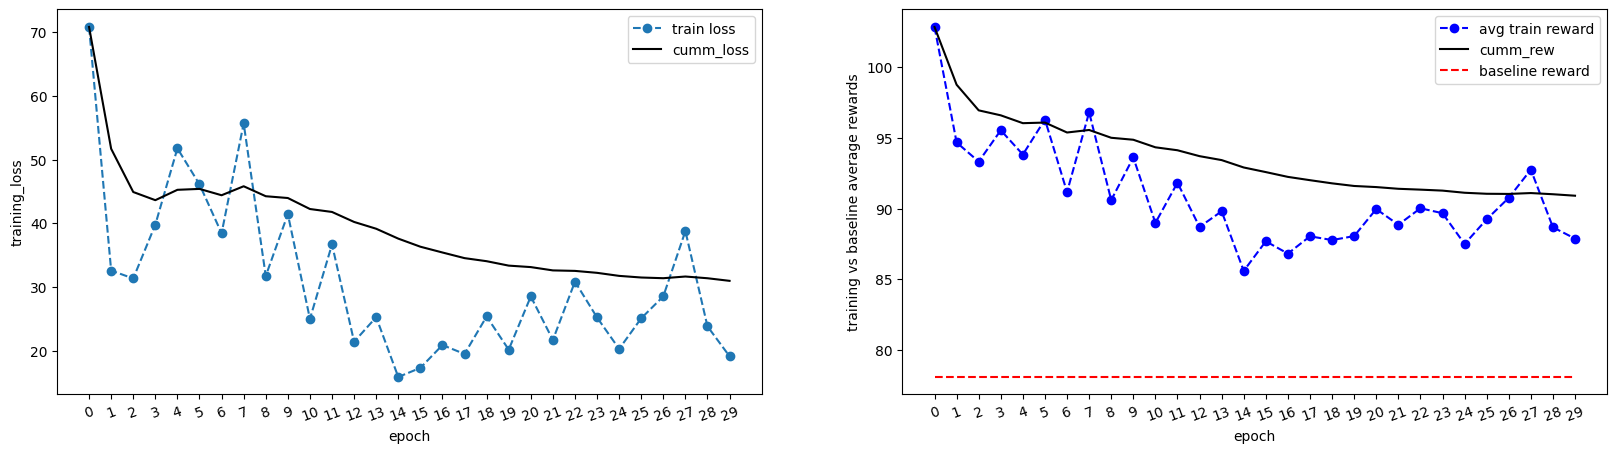

In [ ]:
# Plotting training loss and avg rewards over iterations

n_epochs = training_params["n_epochs"]
train_df["loss"] = losses
x = [e for e in range (n_epochs)]
default_x_ticks = range(len(x))
fig = plt.figure(figsize=(20 ,5))


plt.subplot(121)
train_df["loss"].plot(style='o--', label="train loss")
train_df['loss'].expanding().mean().plot(style='k-', label="cumm_loss")
plt.legend()
plt.xlabel("epoch")
plt.xticks(default_x_ticks, x, rotation=20)
plt.ylabel("training_loss")


plt.subplot(122)
train_df["rew"].plot(style='bo--', label="avg train reward")
train_df['rew'].expanding().mean().plot(style='k-', label="cumm_rew")
train_df["bl_rew"].plot(style='r--', label="baseline reward")
plt.xlabel("epoch")
plt.xticks(default_x_ticks, x, rotation=20)
plt.ylabel("training vs baseline average rewards")


plt.legend()
plt.show()

In [ ]:
# Perform train and test collections on the trained model

train_result = train_collector.collect(n_episode=len(load_train_graphs))
test_result = test_collector.collect(n_episode=len(load_test_graphs))
print(test_result)
train_df["rew"] = 1000*train_df["rew"]
train_df["bl_rew"] = 1000*train_df["bl_rew"]
train_df

{'n/ep': 5000, 'n/st': 64749, 'rews': array([39.9722, 81.7247, 66.9655, ..., 80.6257, 86.9998, 87.347 ]), 'bl_rews': array([43.7215, 74.6908, 67.5235, ..., 70.8813, 98.171 , 67.7623]), 'lens': array([11, 11, 11, ..., 14, 14, 14]), 'idxs': array([ 54422, 242822, 256622, ..., 994828, 998028, 998628]), 'rew': 90.11299231999999, 'bl_rew': 78.37324466, 'len': 12.9498, 'rew_std': 22.480421865381462, 'len_std': 0.5963891011747281}


,test_reward,test_reward_std,best_reward,best_reward_std,best_epoch,loss,gradient_step,env_step,rew,bl_rew,len,n/ep,n/st,epoch
0,95.164130,24.376986,95.164130,24.376986,1,70.822020,506,129771,102808.56190,78111.31018,12,10000,129771,1
1,93.531491,24.290784,93.531491,24.290784,2,32.591595,1013,259705,94662.31280,78111.31018,12,10000,129934,2
2,95.294645,24.636420,93.531491,24.290784,2,31.350644,1519,389432,93309.01441,78111.31018,12,10000,129727,3
3,93.980357,23.695659,93.531491,24.290784,2,39.797032,2026,519296,95520.21626,78111.31018,12,10000,129864,4
4,96.391674,23.269362,93.531491,24.290784,2,51.773236,2533,649098,93808.67521,78111.31018,12,10000,129802,5
5,91.538372,23.143479,91.538372,23.143479,6,46.117920,3040,778895,96277.84473,78111.31018,12,10000,129797,6
6,96.903914,22.382721,91.538372,23.143479,6,38.448014,3547,908718,91157.42040,78111.31018,12,10000,129823,7
7,90.582170,22.630821,90.582170,22.630821,8,55.690617,4053,1038505,96788.35061,78111.31018,12,10000,129787,8
8,93.573189,21.537861,90.582170,22.630821,8,31.740594,4559,1168265,90592.31789,78111.31018,12,10000,129760,9
9,89.450195,22.025135,89.450195,22.025135,10,41.453883,5065,1297935,93601.98993,78111.31018,12,10000,129670,10


In [ ]:
test_result

{'n/ep': 5000,
 'n/st': 64749,
 'rews': array([39.9722, 81.7247, 66.9655, ..., 80.6257, 86.9998, 87.347 ]),
 'bl_rews': array([43.7215, 74.6908, 67.5235, ..., 70.8813, 98.171 , 67.7623]),
 'lens': array([11, 11, 11, ..., 14, 14, 14]),
 'idxs': array([ 54422, 242822, 256622, ..., 994828, 998028, 998628]),
 'rew': 90.11299231999999,
 'bl_rew': 78.37324466,
 'len': 12.9498,
 'rew_std': 22.480421865381462,
 'len_std': 0.5963891011747281}

In [ ]:
# Studying and Plotting collected train and test solutions (distance values are abs(rewards))

def get_distances(rewards):
    distances = np.array([round(abs(rew),3) for rew in rewards])
    return distances


# Get computed distance values from the reward list
test_distances = get_distances(test_result["rews"])
test_bl_distances = get_distances(test_result["bl_rews"])

train_distances = get_distances(train_result["rews"])
train_bl_distances = get_distances(train_result["bl_rews"])

In [ ]:
avg_test_rew, best_test_rew  = round(np.mean(test_distances, axis=0),3), np.min(test_distances, axis=0)
avg_test_rew_bl, best_test_rew_bl = round(np.mean(test_bl_distances, axis=0),3), np.min(test_bl_distances, axis=0)


avg_train_rew, best_train_rew  = round(np.mean(train_distances, axis=0),3), np.min(train_distances, axis=0)
avg_train_rew_bl, best_train_rew_bl = round(np.mean(train_bl_distances, axis=0),3), np.min(train_bl_distances, axis=0)


print("TEST RESULTS")
print(f"Mean test reward: {avg_test_rew}")
print(f"Best test reward: {best_test_rew}")
print(f"\nMean baseline reward: {avg_test_rew_bl}")
print(f"Best baseline reward: {best_test_rew_bl}")

print("\n----------------\n")
print("TRAIN RESULTS")
print(f"Mean train reward: {avg_train_rew}")
print(f"Best train reward: {best_train_rew}")
print(f"\nMean baseline reward: {avg_train_rew_bl}")
print(f"Best baseline reward: {best_train_rew_bl}")

TEST RESULTS
Mean test reward: 90.113
Best test reward: 37.093

Mean baseline reward: 78.373
Best baseline reward: 30.641

----------------

TRAIN RESULTS
Mean train reward: 89.987
Best train reward: 33.091

Mean baseline reward: 78.111
Best baseline reward: 21.738


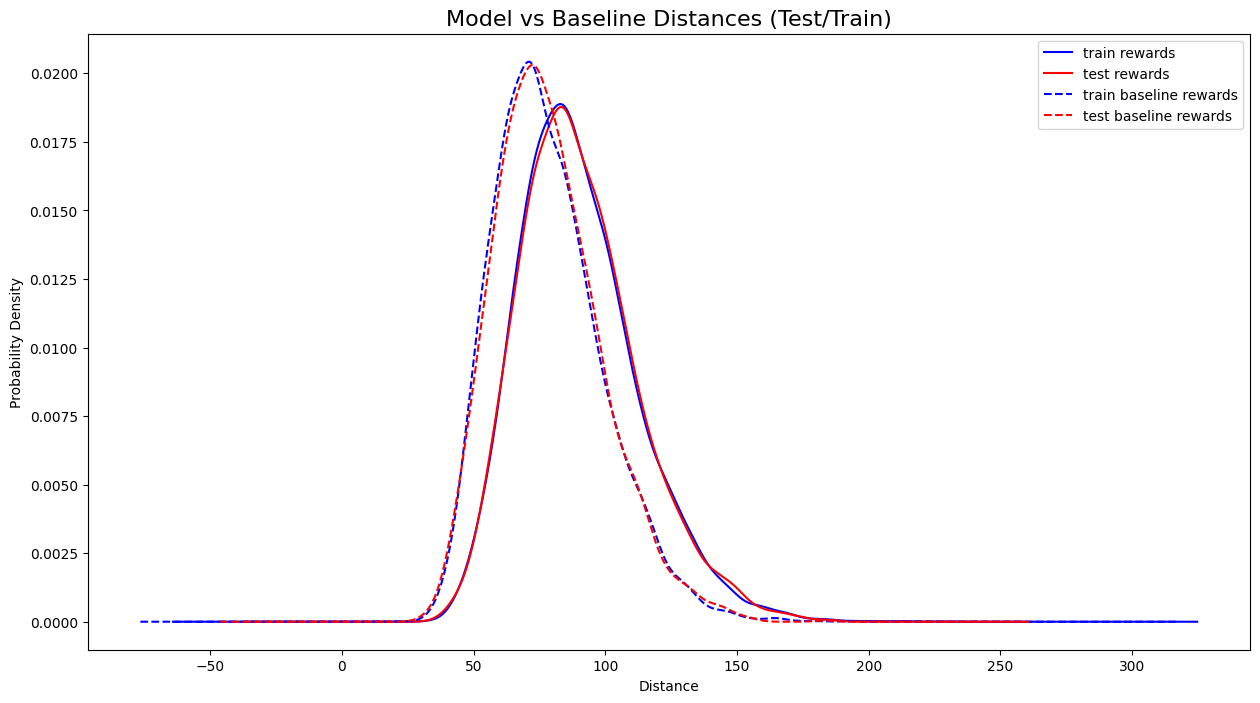

In [ ]:
# Plotting test and train distance values

fig = plt.figure(figsize=(15 ,8))

pd.Series(train_distances).plot.kde(style='b-', label="train rewards")
pd.Series(test_distances).plot.kde(style='r-', label="test rewards")

pd.Series(train_bl_distances).plot.kde(style='b--', label="train baseline rewards")
pd.Series(test_bl_distances).plot.kde(style='r--', label="test baseline rewards")

plt.xlabel("Distance")
plt.ylabel("Probability Density")
plt.title("Model vs Baseline Distances (Test/Train)", size=16)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


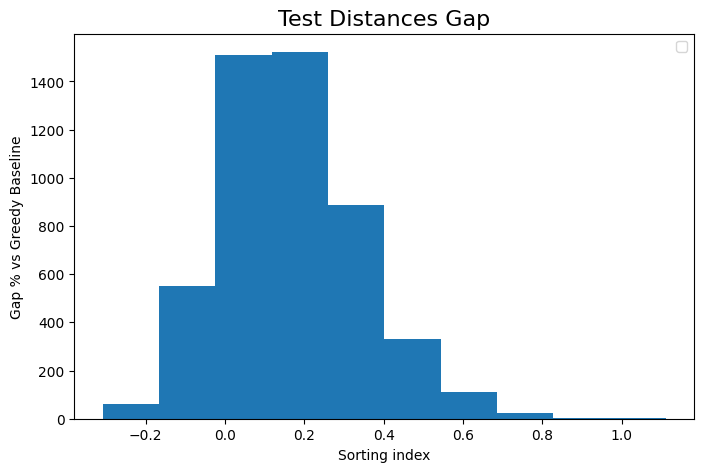

In [ ]:
# Gap between test distances and corresponding baseline solutions
fig = plt.figure(figsize=(8 ,5)) 

gaps = []
for i, dist in enumerate(test_distances):
    gap = (test_distances[i] - test_bl_distances[i]) / test_bl_distances[i]
    gaps.append(gap)
    
    
gaps = np.sort(np.array(gaps))
plt.hist(gaps, bins=10)
#plt.plot(base)

plt.xlabel("Sorting index")
plt.ylabel("Gap % vs Greedy Baseline")
plt.title("Test Distances Gap", size=16)
plt.legend()

In [ ]:
test_distances

array([39.972, 81.725, 66.966, ..., 80.626, 87.   , 87.347])

In [ ]:
test_buffer_df = decode_buffer(test_replaybuffer)
#train_buffer_df = decode_buffer(train_replaybuffer)
test_buffer_df

,index,env_id,curr_pos,curr_capacity,possible_actions,action,reward,bl_action,bl_reward,done
0,0,0,0,1.00,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],10,7.1740,6,4.3896,False
1,1,0,10,0.75,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.],6,5.2521,3,4.0618,False
2,2,0,6,0.46,[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.],3,4.0618,2,2.1273,False
3,3,0,3,0.35,[1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.],2,2.1273,10,6.1594,False
4,4,0,2,0.22,[1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.],0,0.0000,7,11.1987,False
...,...,...,...,...,...,...,...,...,...,...
194242,999834,4999,1,0.06,[1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.],0,0.0000,0,0.0000,False
194243,999835,4999,0,1.00,[1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.],7,12.4444,6,19.8138,False
194244,999836,4999,7,0.83,[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.],4,5.7105,9,6.0529,False
194245,999837,4999,4,0.54,[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.],8,11.4684,0,0.0000,False


In [ ]:
test_buffer_df.head(50)

,index,env_id,curr_pos,curr_capacity,possible_actions,action,reward,bl_action,bl_reward,done
0,0,0,0,1.00,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],10,7.1740,6,4.3896,False
1,1,0,10,0.75,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.],6,5.2521,3,4.0618,False
2,2,0,6,0.46,[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.],3,4.0618,2,2.1273,False
3,3,0,3,0.35,[1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0.],2,2.1273,10,6.1594,False
4,4,0,2,0.22,[1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.],0,0.0000,7,11.1987,False
5,5,0,0,1.00,[1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.],1,19.0962,0,0.0000,False
6,6,0,1,0.67,[1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.],5,16.7059,4,14.3677,False
7,7,0,5,0.35,[1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.],8,12.8377,8,9.8393,False
8,8,0,8,0.09,[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.],0,0.0000,0,0.0000,False
9,9,0,0,1.00,[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.],4,14.3677,1,19.0962,False


In [ ]:
#train_rewards_df = train_buffer_df.groupby(['env_id']).agg(action_count=('action', 'count'), 
#                                        reward=('reward', 'sum'), 
#                                       bl_reward=('bl_reward', 'sum'))
#
#train_rewards_df

In [ ]:
test_rewards_df = test_buffer_df.groupby(['env_id']).agg(action_count=('action', 'count'), 
                                        reward=('reward', 'sum'), 
                                       bl_reward=('bl_reward', 'sum'))


test_rewards_df["avg_reward"] = test_rewards_df["reward"] * training_params["graph_size"] / test_rewards_df["action_count"]
test_rewards_df["avg_bl_reward"] = test_rewards_df["bl_reward"] * training_params["graph_size"] / test_rewards_df["action_count"]
test_rewards_df["reward_gap"] = test_rewards_df["avg_reward"] - test_rewards_df["avg_bl_reward"]
test_rewards_df["gap"] = test_rewards_df["reward_gap"]*100 / test_rewards_df["avg_bl_reward"]

test_rewards_df.sort_values("gap")

,action_count,reward,bl_reward,avg_reward,avg_bl_reward,reward_gap,gap
env_id,,,,,,,
3280,39,172.0713,248.8383,44.120846,63.804692,-19.683846,-30.850154
4194,39,384.4410,552.5982,98.574615,141.691846,-43.117231,-30.430284
1222,39,186.4929,262.9224,47.818692,67.416000,-19.597308,-29.069223
2010,39,243.6345,337.8978,62.470385,86.640462,-24.170077,-27.896985
3737,39,212.9964,293.0784,54.614462,75.148308,-20.533846,-27.324429
...,...,...,...,...,...,...,...
3970,36,213.9870,112.9563,59.440833,31.376750,28.064083,89.442289
4470,42,350.8974,184.2528,83.547000,43.869714,39.677286,90.443456
216,36,210.8169,106.8036,58.560250,29.667667,28.892583,97.387448


In [ ]:
tours, bl_tours = generate_tours(test_buffer_df, test_result)

In [ ]:
tours[:10]

NameError: name 'tours' is not defined

In [ ]:
idx = 50

graph_data = load_test_graphs[idx]
graph_route = tours[idx]
graph_route_bl = bl_tours[idx]

fig, ax = plt.subplots(figsize=(5, 5))
plot_vehicle_routes(graph_data, graph_route, ax, visualize_demands=False, demand_scale=50, round_demand=True)

#plt.subplot(122)
#plot_vehicle_routes(graph_data, graph_route_bl, ax, visualize_demands=False, demand_scale=50, round_demand=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_vehicle_routes(graph_data, graph_route_bl, ax, visualize_demands=False, demand_scale=50, round_demand=True)

In [ ]:
# Save the buffer and training results as a csv_file

#buff_file_path = "./results/buffer/" + f"test_buffer_exp{exp_num}_train{len(load_train_graphs)}_test{len(load_test_graphs)}.csv"
#train_file_path = "./results/training/" + f"train_results_exp{exp_num}_train{len(load_train_graphs)}_test{len(load_test_graphs)}.csv"
#
#test_buffer_df.to_csv(buff_file_path)
#train_df.to_csv(train_file_path)

In [ ]:
now

In [ ]:
## Save the trained model with current timestamp
now = datetime.now()
now = now.strftime("%m/%d/%Y|%H:%M:%S")
#
file_path = "./trained_models/" + f"model_AM_exp{exp_num}_{n_epochs}epochs -- ({now}) train{len(load_train_graphs)}_test{len(load_test_graphs)}.pth"
torch.save(model.state_dict(), file_path)

In [ ]:
#train_buffer_df = decode_buffer(train_replaybuffer)
#train_buffer_df

In [ ]:
# Save the buffer and training results as a csv_file

#buff_file_path = "./results/" + f"train_buffer_exp{exp_num}_train{len(load_train_graphs)}_test{len(load_test_graphs)}.csv"
#train_buffer_df.to_csv(buff_file_path)

In [ ]:
#logs_base_dir = "./logs"
#os.makedirs(logs_base_dir, exist_ok=True)
#%tensorboard --logdir {logs_base_dir}

In [ ]:
#pip uninstall tensorflow

In [ ]:
#pip uninstall tensorboard

In [ ]:
test_buffer_df

In [ ]:
#import shutil
#
#file_name = "RealisticVRP-dev"
#dir_name = "./"
#
#shutil.make_archive(file_name, 'zip', dir_name)

In [ ]:
test_buffer_df.head(50)